# Load Station Status Stream Files

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import datetime
import math

import seaborn as sns
sns.set()

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
font = {'size'   : 50}
matplotlib.rc('font', **font)

LABEL_FONT_SIZE = 15
TITLE_FONT_SIZE = 25

## Import Data

In [32]:
def load_status_data():

    print('Loading Status Data...')
    file_path_slug = '../source_data/streamed_*/ba/*station_status*.csv'

    # glob all files
    file_list = glob(file_path_slug)

    df = pd.DataFrame()
    chunks = []
    counter = 0
    
    print('Started Import (%s files to load)...' % len(file_list))

    # load data from each file
    for file in file_list:
        try:

            # import file in chunks
            chunk = pd.read_csv(file)

            # add program id to chunk
            chunk['program_id'] = str(file).split('/')[3]

            # append chunk to chunks list
            chunks.append(chunk)
            
            counter += 1
            if counter == 1 or counter % math.ceil(len(file_list)/10) == 0 or counter == len(file_list):
                print('\tFinished file! (%d of %d)' % (counter, len(file_list)))        
        except:
            print(file)

    df = pd.concat(chunks)
    print('Data Loaded Successfully!\n')
    return df
    
def clean_data(df):
    program_list = sorted(pd.unique(df.program_id))
    print('Started cleaning (%s programs to clean)...' % len(program_list))
    df.rename(columns={'last_reported' : 'time',
                                     'eightd_has_available_keys' : 'has_available_keys',
                                     'is_installed' : 'is_installed',
                                     'is_renting' : 'is_renting',
                                     'is_returning' : 'is_returning',
                                     'num_bikes_available' : 'bikes_available',
                                     'num_bikes_disabled' : 'bikes_disabled',
                                     'num_docks_available' : 'docks_available',
                                     'num_docks_disabled' : 'docks_disabled',
                                     'station_id' : 'station_id'}, inplace=True)

    drop_cols = ['eightd_active_station_services', 'has_available_keys', 'is_installed', 'is_renting', 'is_returning', 'bikes_disabled', 'docks_disabled', 'renting', 'returning', 'installed']

    for c in drop_cols:
        try:
            df.drop(c, axis=1, inplace=True)
        except:
            pass

    # convert time to datetime, and prune entries pre 2000, some epoch dates are being reported
    df['time'] = pd.to_datetime(df['time'], format="%Y-%m-%d %H:%M:%S")
    change_date = pd.Timestamp('2000-01-01 00:00')
    df = df[df.time >= change_date].copy()

    df.sort_values(['program_id', 'station_id', 'time'], inplace=True)
    
    A = len(df)
    df.drop_duplicates(subset=['time', 'program_id', 'station_id'], inplace=True)
    B = len(df)
    print('\t\tDropped %s duplicates!' % (A-B))
    
    # by program and station ,append dock change and bike change
    cleaned_df = pd.DataFrame()
    cleaned_list = []
    counter = 1
    for pid in program_list:

        df_temp_program = df[df.program_id == pid].copy()

        # for each dock
        print('%s\t%s - %s Stations to Clean...' % (str(counter).rjust(3), pid.ljust(25), str(len(pd.unique(df_temp_program.station_id))).rjust(4)))
        for sid in pd.unique(df_temp_program.station_id):
            df_temp_station = df_temp_program[df_temp_program.station_id == sid].copy()
            
            # drop duplicates
            A = len(df_temp_station)
            df_temp_station.drop_duplicates(subset='time', inplace=True)
            B = len(df_temp_station)
            if A != B:
                print('\t%s\tDropped %s duplicates!' % (sid, (A-B)))
            
            df_temp_station.sort_values(['time'], inplace=True)
            
            df_temp_station['trips_ending'] = df_temp_station['bikes_available'].diff().apply(lambda x: x if x > 0 else 0)
            df_temp_station['trips_starting'] = df_temp_station['docks_available'].diff().apply(lambda x: x if x > 0 else 0)
            df_temp_station['net_traffic'] = df_temp_station['trips_starting'] - df_temp_station['trips_ending']

            cleaned_list.append(df_temp_station)
            
        counter += 1

    print('Merging DataFrame...')
    cleaned_df = pd.concat(cleaned_list)
    cleaned_df.reset_index(inplace=True, drop=True)

    print('Cleaning Complete!')

    return cleaned_df


In [33]:
status_import = load_status_data()

Loading Status Data...
Started Import (3128 files to load)...
	Finished file! (1 of 3128)
	Finished file! (313 of 3128)
	Finished file! (626 of 3128)
	Finished file! (939 of 3128)
	Finished file! (1252 of 3128)
	Finished file! (1565 of 3128)
	Finished file! (1878 of 3128)
	Finished file! (2191 of 3128)
	Finished file! (2504 of 3128)
	Finished file! (2817 of 3128)
	Finished file! (3128 of 3128)
Data Loaded Successfully!



In [34]:
status_data = clean_data(status_import)

Started cleaning (1 programs to clean)...
		Dropped 3550854 duplicates!
  1	ba                        -  268 Stations to Clean...
Merging DataFrame...
Cleaning Complete!


In [35]:
status_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173068 entries, 0 to 173067
Data columns (total 8 columns):
time               173068 non-null datetime64[ns]
bikes_available    173068 non-null int64
docks_available    173068 non-null int64
station_id         173068 non-null int64
program_id         173068 non-null object
trips_ending       173068 non-null float64
trips_starting     173068 non-null float64
net_traffic        173068 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 10.6+ MB


In [36]:
status_data.head(5)

,time,bikes_available,docks_available,station_id,program_id,trips_ending,trips_starting,net_traffic
0,2017-11-13 14:53:59,11,24,3,ba,0.0,0.0,0.0
1,2017-11-13 16:20:11,9,26,3,ba,0.0,2.0,2.0
2,2017-11-13 16:33:36,10,25,3,ba,1.0,0.0,-1.0
3,2017-11-13 16:39:57,11,24,3,ba,1.0,0.0,-1.0
4,2017-11-13 16:45:19,10,25,3,ba,0.0,1.0,1.0


In [9]:
def show_station(df, id, x_label = '', y_label = '', title_suffix='', color='b', col='bikes_available'):
    t = df[df.station_id == id]
    t.set_index('time', inplace=True)
    ax = t[col].cumsum().plot(color=color, figsize=(24,3))
    if title_suffix != '':
        title = 'Station %s - %s' % (id, title_suffix)
    elif y_label != '':
        title = 'Station %s - %s' % (id, y_label)
    else:
        title = 'Station %s' % id
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')
    ax.set_xlabel(x_label, size=LABEL_FONT_SIZE, weight='bold')
    ax.set_ylabel(y_label, size=LABEL_FONT_SIZE, weight='bold')
    plt.show()

In [10]:
def plot_hourly_usage(df, title='CoGo', color='r'):
    
    try:
        df.sort_values('time', inplace=True)
        x_ticks = sorted(pd.unique(df.time.dt.hour))
        df_data = df[df.bike_change != 0]
        df_data.reset_index(inplace=True, drop=True)
        df_status_change = df_data.groupby([df_data.time.dt.hour])['station_id'].count()

        plt.subplots(figsize=(24,3))
        ax = sns.barplot(x = df_status_change.index , y = df_status_change, color=color, alpha = 0.25, label=title)
        ax.set_title('Distribution of Trips by Hour', size=TITLE_FONT_SIZE, weight='bold')
        ax.set_xlabel('Start Hour', size=LABEL_FONT_SIZE, weight='bold')
        ax.set_ylabel('Total Trips', size=LABEL_FONT_SIZE, weight='bold')
        ax.set_xticks(x_ticks)
        plt.legend()
        plt.show()
    except:
        print('Unable to plot %s' % title)

In [11]:
def resample_status(df, interval='5T', verbose=False):
    if verbose:
        print('[%s] Resampling on interval' % datetime.datetime.now().time())
    
    resampled_list = []
    
    for pid in pd.unique(df.program_id):

            df_temp = df[df.program_id == pid].copy()
            
            df_temp.set_index(['station_id', 'time'], inplace=True)

            # resample on 5 minute interval mean
            df_temp = df_temp.groupby([pd.Grouper(level=0), pd.Grouper(freq=interval, level=-1)]).mean()
            df_temp.reset_index(inplace=True)
            
            df_temp['program_id'] = pid
         
            resampled_list.append(df_temp)

    resampled_df = pd.concat(resampled_list)
    resampled_df.reset_index(inplace=True, drop=True)
    
    if verbose:
        print('[%s] Complete' % datetime.datetime.now().time())
    return resampled_df

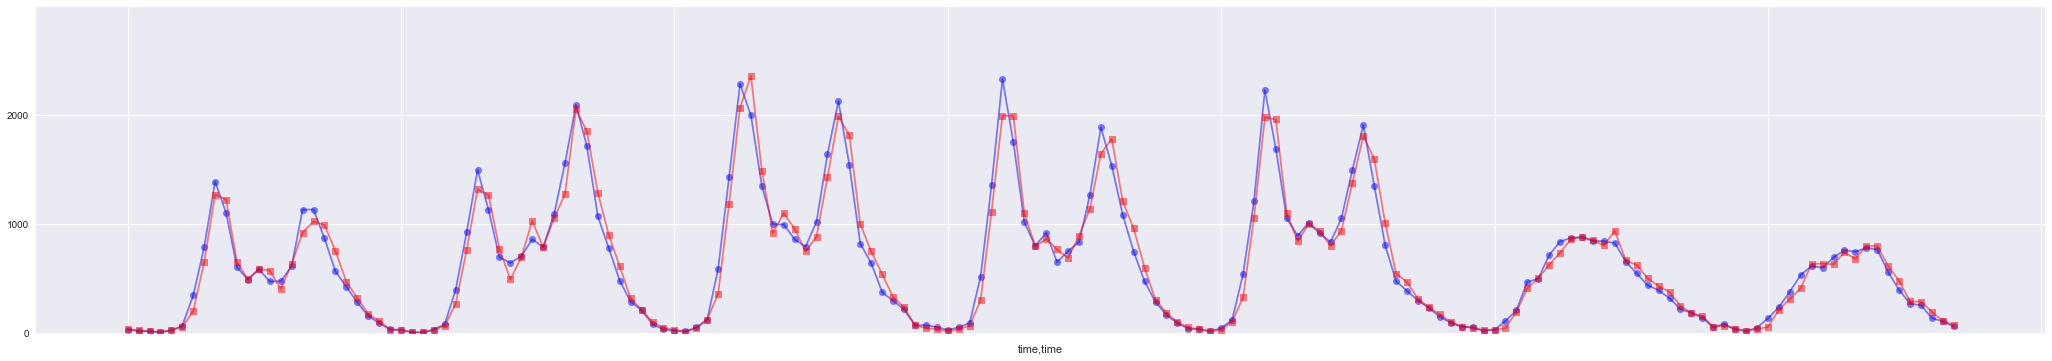

In [12]:
d0 = status_data.groupby([status_data.time.dt.dayofweek, status_data.time.dt.hour]).trips_starting.sum()
d1 = status_data.groupby([status_data.time.dt.dayofweek, status_data.time.dt.hour]).trips_ending.sum()

ax = d0.plot(figsize=(36,6), color='b', alpha=0.5, marker='o')
d1.plot(ax=ax, color='r', alpha=0.5, marker='s')


y_tick_interval = 1000
y_max = math.ceil(d0.max()/y_tick_interval)*y_tick_interval

if math.ceil(d1.max()/y_tick_interval)*y_tick_interval > y_max:
    y_max = math.ceil(d1.max()/y_tick_interval)*y_tick_interval

y_tick_max = int(y_max/y_tick_interval*1.1)

ax.set_ylim(0, y_max)
ax.set_yticks([y*y_tick_interval for y in range(0, y_tick_max)])

plt.show()

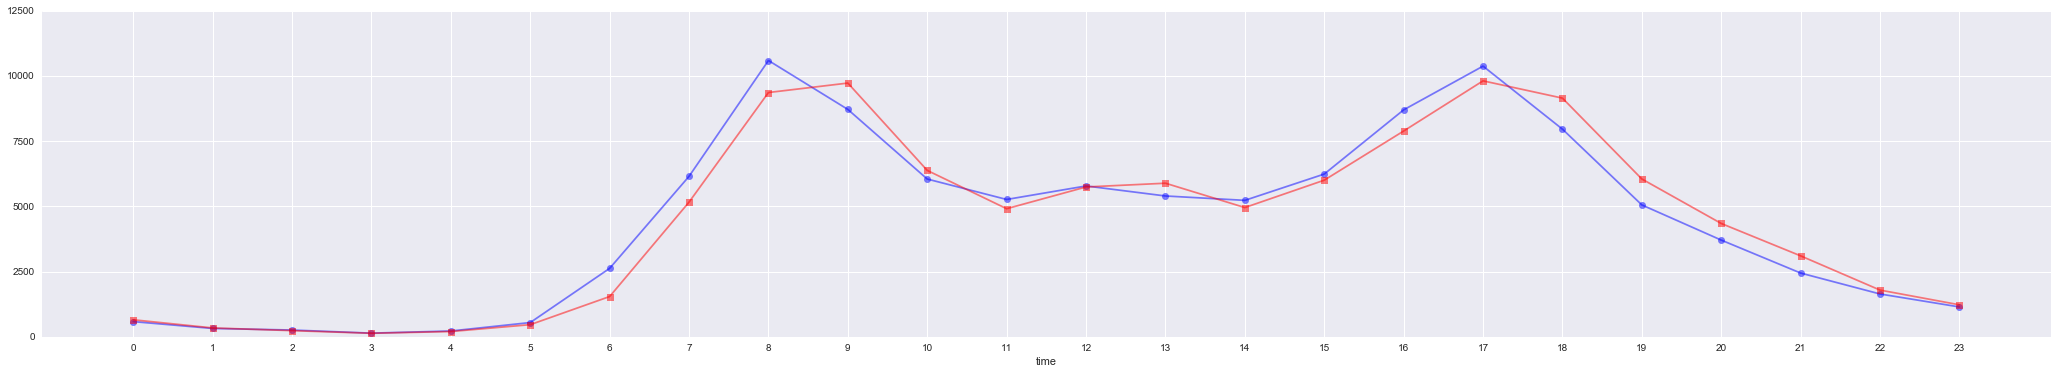

In [13]:
fig, ax = plt.subplots(figsize=(36,6))
y_max = 0
for pid in pd.unique(status_data.program_id):
    d0 = status_data[status_data.program_id == pid].groupby([status_data.time.dt.hour]).trips_starting.sum()
    d0.plot(color='b', alpha= 0.5, ax=ax, marker='o')
    
    if d0.max() > y_max:
        y_max = d0.max()
    
    d1 = status_data[status_data.program_id == pid].groupby([status_data.time.dt.hour]).trips_ending.sum()
    d1.plot(color='r', alpha= 0.5, ax=ax, marker='s')
        
    if d1.max() > y_max:
        y_max = d1.max()

y_tick_interval = 2500
y_max = math.ceil(y_max/y_tick_interval)*y_tick_interval
y_tick_max = int(y_max/y_tick_interval)+1
x_ticks = sorted(pd.unique(status_data.time.dt.hour))
ax.set_xticks(x_ticks)
ax.set_ylim(0, y_max)
ax.set_yticks([y*y_tick_interval for y in range(0, y_tick_max)])

plt.show()

In [14]:
print('Program ID\t\tTrips Starting\t\tTrips Ending\t\tNet')
for pid in pd.unique(status_data.program_id):
    S = status_data[status_data.program_id == pid].trips_starting.sum()
    E = status_data[status_data.program_id == pid].trips_ending.sum()
    print('%s\t%s\t\t%s\t\t%s' % (pid.rjust(15), str(S).rjust(15), str(E).rjust(15), str(S-E).rjust(15)))

Program ID		Trips Starting		Trips Ending		Net
             ba	       105114.0		       105040.0		           74.0


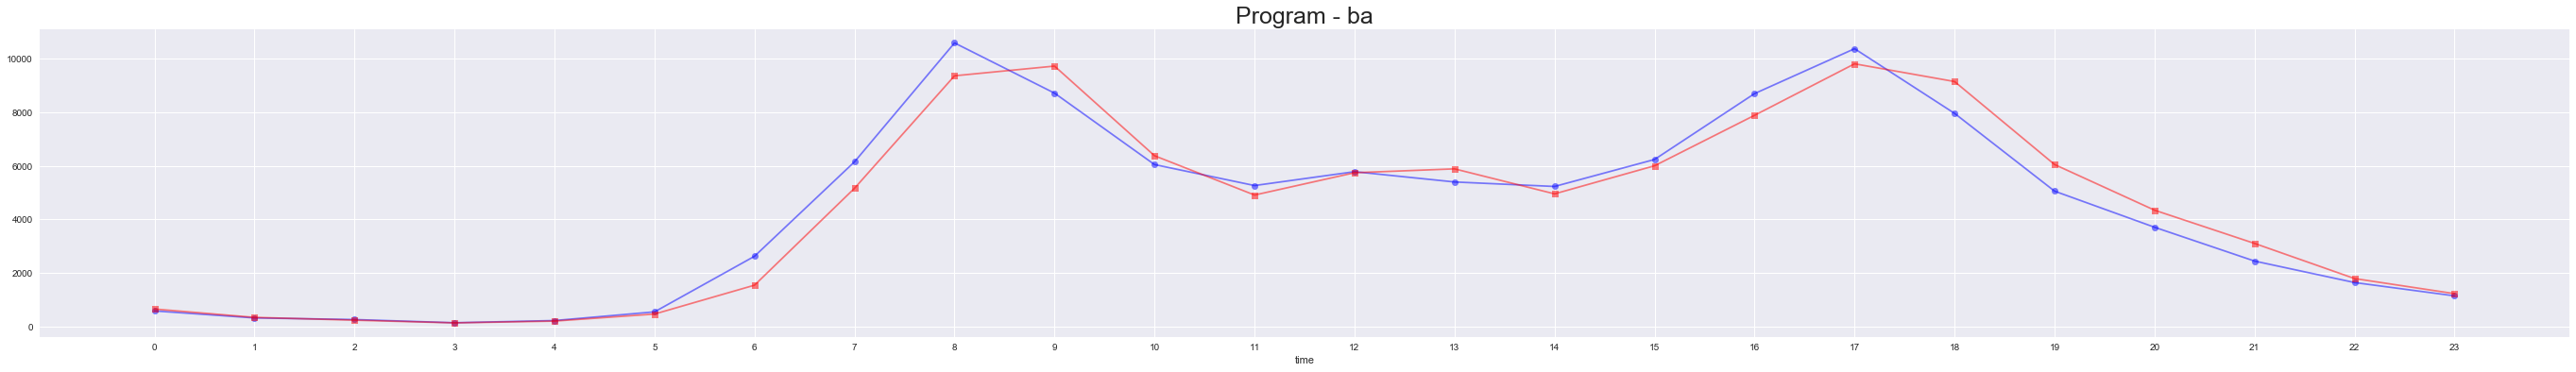

In [15]:
for pid in pd.unique(status_data.program_id):
    fig, ax = plt.subplots(figsize=(48,6))
    data = status_data[status_data.program_id == pid].groupby([status_data.time.dt.hour])
    data.trips_starting.sum().plot(kind ='line', color='b', alpha= 0.5, ax=ax, marker='o')
    data.trips_ending.sum().plot(kind ='line', color='r', alpha= 0.5, ax=ax, marker='s')
    title = 'Program - %s' % pid
    ax.set_title(title, size=TITLE_FONT_SIZE)
    x_ticks = range(0, 24)
    ax.set_xticks(x_ticks)
    plt.show()

Program ID			Trips Starting	Trips Ending	Net
ba                       	105114.0		105040.0		74.0


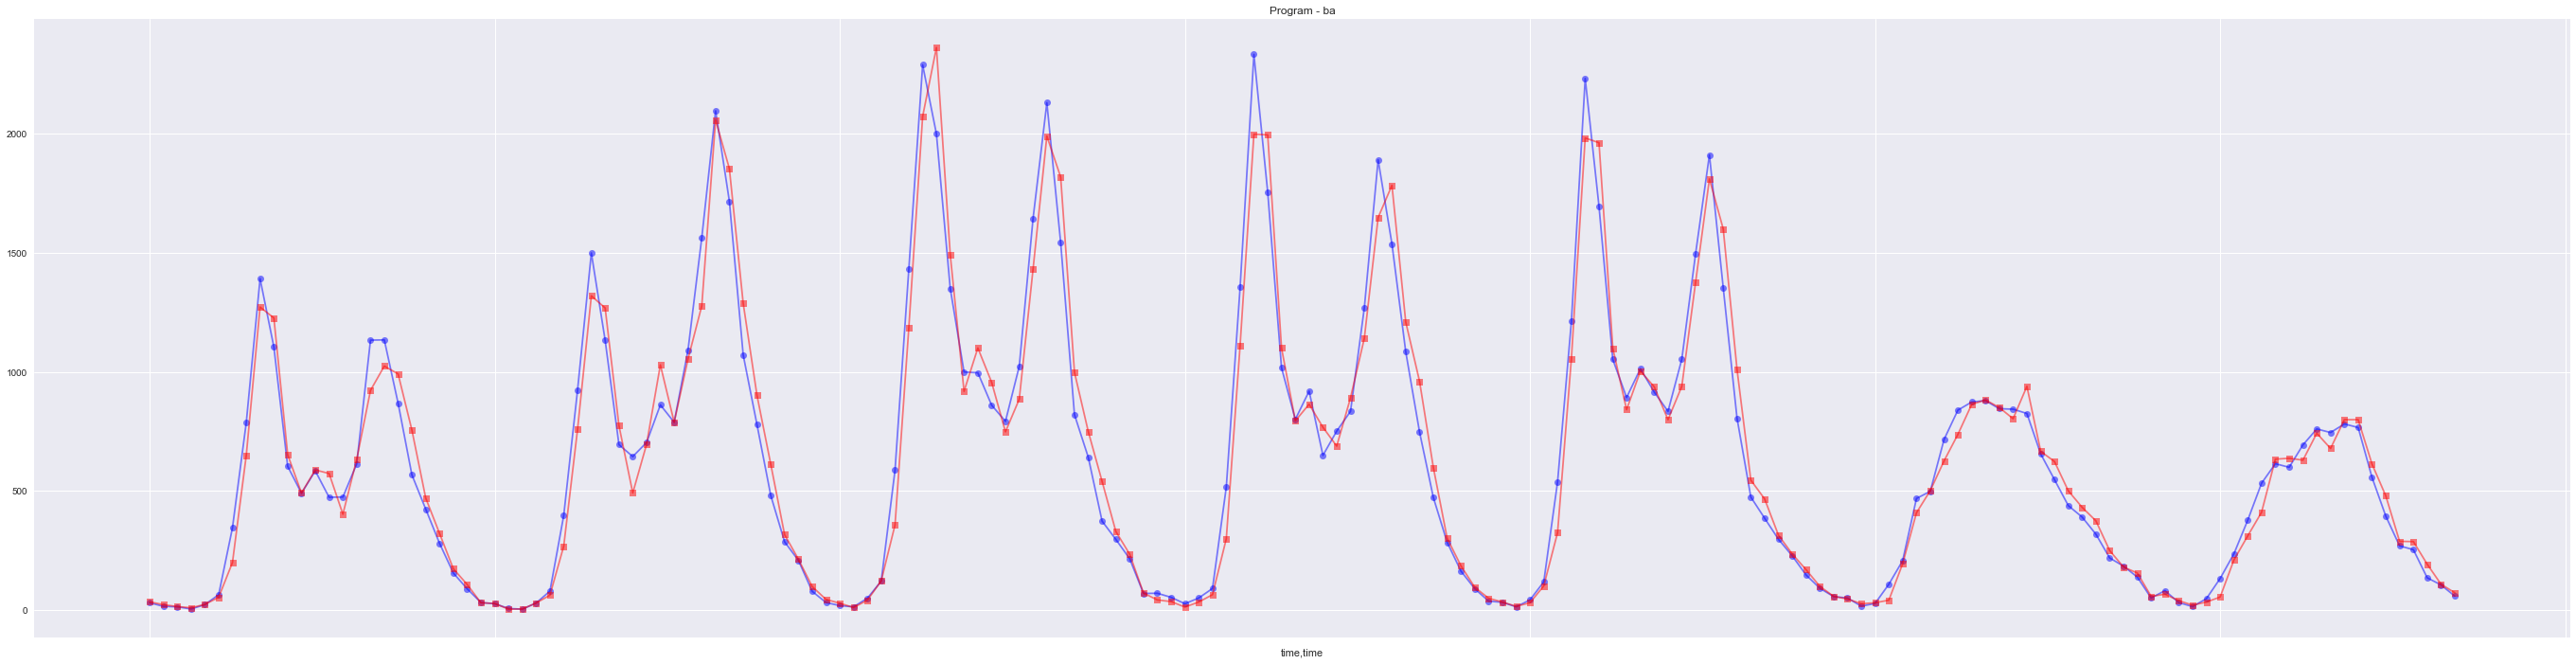

In [16]:
print('Program ID\t\t\tTrips Starting\tTrips Ending\tNet')
for pid in pd.unique(status_data.program_id):
    S = status_data[status_data.program_id == pid].trips_starting.sum()
    if S > 50000:
        E = status_data[status_data.program_id == pid].trips_ending.sum()
        print('%s\t%s\t\t%s\t\t%s' % (pid.ljust(25), str(S), str(E), S-E))
        fig, ax = plt.subplots(figsize=(48,12))
        data = status_data[status_data.program_id == pid].groupby([status_data.time.dt.dayofweek, status_data.time.dt.hour])
        data.trips_starting.sum().plot(kind ='line', color='b', alpha= 0.5, ax=ax, marker='o')
        data.trips_ending.sum().plot(kind ='line', color='r', alpha= 0.5, ax=ax, marker='s')
        title = 'Program - %s' % pid
        ax.set_title(title)
        plt.show()

Program ID			Trips Starting	Trips Ending	Net
ba                       	105114.0		105040.0		74.0


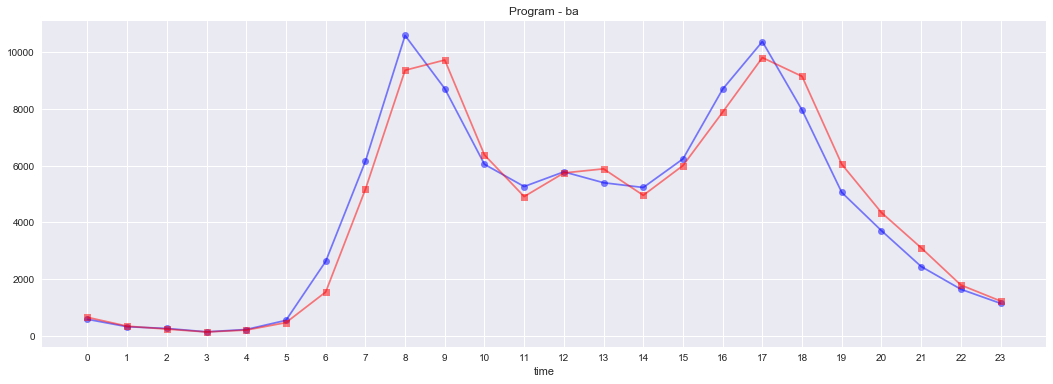

In [17]:
print('Program ID\t\t\tTrips Starting\tTrips Ending\tNet')
for pid in pd.unique(status_data.program_id):
    S = status_data[status_data.program_id == pid].trips_starting.sum()
    if S > 50000:
        E = status_data[status_data.program_id == pid].trips_ending.sum()
        print('%s\t%s\t\t%s\t\t%s' % (pid.ljust(25), str(S), str(E), S-E))
        fig, ax = plt.subplots(figsize=(18,6))
#         data = status_data_resample[status_data_resample.program_id == pid].groupby([status_data_resample.time.dt.dayofweek, status_data_resample.time.dt.hour])
        data = status_data[status_data.program_id == pid].groupby([status_data.time.dt.hour])
        data.trips_starting.sum().plot(kind ='line', color='b', alpha= 0.5, ax=ax, marker='o')
        data.trips_ending.sum().plot(kind ='line', color='r', alpha= 0.5, ax=ax, marker='s')
        title = 'Program - %s' % pid
        ax.set_title(title)
        x_ticks = range(0, 24)
        ax.set_xticks(x_ticks)
        plt.show()

In [18]:
status_data.head()

,time,bikes_available,docks_available,station_id,program_id,trips_ending,trips_starting,net_traffic
0,2017-11-13 14:53:59,11,24,3,ba,0.0,0.0,0.0
1,2017-11-13 16:20:11,9,26,3,ba,0.0,2.0,2.0
2,2017-11-13 16:33:36,10,25,3,ba,1.0,0.0,-1.0
3,2017-11-13 16:39:57,11,24,3,ba,1.0,0.0,-1.0
4,2017-11-13 16:45:19,10,25,3,ba,0.0,1.0,1.0


# Import Station Information File JSON

In [19]:
from pandas.io.json import json_normalize
import json

In [20]:
station_info_file = './ford_go_bike_station_information.json'

with open(station_info_file) as data:
    payload = json.load(data)

In [21]:
station_data = payload['data']['stations']

In [22]:
# converting json dataset from dictionary to dataframe
FGB_stations = pd.DataFrame.from_dict(station_data)
FGB_stations.drop(['eightd_has_key_dispenser', 'rental_url', 'rental_methods'], inplace=True, axis=1)
FGB_stations['station_id'] = FGB_stations['station_id'].astype('int')
FGB_stations.sort_values('station_id', inplace=True)
FGB_stations.reset_index(inplace=True, drop=True)



In [23]:
FGB_stations.head(20)

,capacity,lat,lon,name,region_id,short_name,station_id
0,35,37.786375,-122.404904,Powell St BART Station (Market St at 4th St),3,SF-G27,3
1,35,37.785881,-122.408915,Cyril Magnin St at Ellis St,3,SF-G26,4
2,35,37.783899,-122.408445,Powell St BART Station (Market St at 5th St),3,SF-H26,5
3,23,37.804770,-122.403234,The Embarcadero at Sansome St,3,SF-A27,6
4,35,37.804562,-122.271738,Frank H Ogawa Plaza,12,OK-L5,7
5,23,37.799953,-122.398525,The Embarcadero at Vallejo St,3,SF-C28-1,8
6,15,37.798572,-122.400869,Broadway at Battery St,3,SF-C28-2,9
7,31,37.795393,-122.404770,Washington St at Kearny St,3,SF-D27,10
8,35,37.797280,-122.398436,Davis St at Jackson St,3,SF-D28,11
9,0,37.796389,-122.394586,Pier 1/2 at The Embarcadero,3,SF-D29,12


In [24]:
for i, name in enumerate(sorted(FGB_stations.name.unique())):
    print('%d\t%s' % (i, name))

0	10th Ave at E 15th St
1	10th St at Fallon St
2	11th St at Bryant St
3	11th St at Natoma St
4	12th St at 4th Ave
5	12th St at 6th Ave
6	13th St at Folsom St
7	13th St at Franklin St
8	14th St at Filbert St
9	14th St at Mandela Pkwy
10	14th St at Mission St
11	16th St Mission BART
12	16th St Mission BART Station 2
13	16th St at Prosper St
14	17th & Folsom Street Park (17th St at Folsom St)
15	17th St at Dolores St
16	17th St at Valencia St
17	18th St at Noe St
18	19th St at Florida St
19	19th St at Mission St
20	19th Street BART Station
21	1st St at Folsom St
22	20th St at Bryant St
23	21st Ave at International Blvd
24	21st St at Mission St
25	22nd St Caltrain Station
26	23rd Ave at Foothill Blvd
27	24th St Mission BART
28	24th St at Chattanooga St
29	24th St at Market St
30	26th Ave at International Blvd
31	27th St at MLK Jr Way
32	29th St at Church St
33	29th St at Tiffany Ave
34	2nd Ave at E 18th St
35	2nd St at Folsom St
36	2nd St at Washington St
37	30th St at San Jose Ave
38	32nd

In [25]:
status_data.head()

,time,bikes_available,docks_available,station_id,program_id,trips_ending,trips_starting,net_traffic
0,2017-11-13 14:53:59,11,24,3,ba,0.0,0.0,0.0
1,2017-11-13 16:20:11,9,26,3,ba,0.0,2.0,2.0
2,2017-11-13 16:33:36,10,25,3,ba,1.0,0.0,-1.0
3,2017-11-13 16:39:57,11,24,3,ba,1.0,0.0,-1.0
4,2017-11-13 16:45:19,10,25,3,ba,0.0,1.0,1.0


In [39]:
status = status_data.merge(FGB_stations, left_on='station_id', right_on='station_id')
status.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170480 entries, 0 to 170479
Data columns (total 14 columns):
time               170480 non-null datetime64[ns]
bikes_available    170480 non-null int64
docks_available    170480 non-null int64
station_id         170480 non-null int64
program_id         170480 non-null object
trips_ending       170480 non-null float64
trips_starting     170480 non-null float64
net_traffic        170480 non-null float64
capacity           170480 non-null int64
lat                170480 non-null float64
lon                170480 non-null float64
name               170480 non-null object
region_id          170480 non-null int64
short_name         170480 non-null object
dtypes: datetime64[ns](1), float64(5), int64(5), object(3)
memory usage: 19.5+ MB


In [41]:
status.head(10)

,time,bikes_available,docks_available,station_id,program_id,trips_ending,trips_starting,net_traffic,capacity,lat,lon,name,region_id,short_name
0,2017-11-13 14:53:59,11,24,3,ba,0.0,0.0,0.0,35,37.786375,-122.404904,Powell St BART Station (Market St at 4th St),3,SF-G27
1,2017-11-13 16:20:11,9,26,3,ba,0.0,2.0,2.0,35,37.786375,-122.404904,Powell St BART Station (Market St at 4th St),3,SF-G27
2,2017-11-13 16:33:36,10,25,3,ba,1.0,0.0,-1.0,35,37.786375,-122.404904,Powell St BART Station (Market St at 4th St),3,SF-G27
3,2017-11-13 16:39:57,11,24,3,ba,1.0,0.0,-1.0,35,37.786375,-122.404904,Powell St BART Station (Market St at 4th St),3,SF-G27
4,2017-11-13 16:45:19,10,25,3,ba,0.0,1.0,1.0,35,37.786375,-122.404904,Powell St BART Station (Market St at 4th St),3,SF-G27
5,2017-11-13 17:00:51,9,26,3,ba,0.0,1.0,1.0,35,37.786375,-122.404904,Powell St BART Station (Market St at 4th St),3,SF-G27
6,2017-11-13 17:07:11,7,28,3,ba,0.0,2.0,2.0,35,37.786375,-122.404904,Powell St BART Station (Market St at 4th St),3,SF-G27
7,2017-11-13 17:25:10,6,29,3,ba,0.0,1.0,1.0,35,37.786375,-122.404904,Powell St BART Station (Market St at 4th St),3,SF-G27
8,2017-11-13 17:27:09,5,30,3,ba,0.0,1.0,1.0,35,37.786375,-122.404904,Powell St BART Station (Market St at 4th St),3,SF-G27
9,2017-11-13 17:39:50,5,30,3,ba,0.0,0.0,0.0,35,37.786375,-122.404904,Powell St BART Station (Market St at 4th St),3,SF-G27


In [42]:
status['utilization'] = status.docks_available / status.capacity * 100.
status.head()

,time,bikes_available,docks_available,station_id,program_id,trips_ending,trips_starting,net_traffic,capacity,lat,lon,name,region_id,short_name,utilization
0,2017-11-13 14:53:59,11,24,3,ba,0.0,0.0,0.0,35,37.786375,-122.404904,Powell St BART Station (Market St at 4th St),3,SF-G27,68.571429
1,2017-11-13 16:20:11,9,26,3,ba,0.0,2.0,2.0,35,37.786375,-122.404904,Powell St BART Station (Market St at 4th St),3,SF-G27,74.285714
2,2017-11-13 16:33:36,10,25,3,ba,1.0,0.0,-1.0,35,37.786375,-122.404904,Powell St BART Station (Market St at 4th St),3,SF-G27,71.428571
3,2017-11-13 16:39:57,11,24,3,ba,1.0,0.0,-1.0,35,37.786375,-122.404904,Powell St BART Station (Market St at 4th St),3,SF-G27,68.571429
4,2017-11-13 16:45:19,10,25,3,ba,0.0,1.0,1.0,35,37.786375,-122.404904,Powell St BART Station (Market St at 4th St),3,SF-G27,71.428571


In [99]:
# data = status[status.station_id == 236].copy()
data = status.copy()

data.groupby('time').sum()['trips_starting'].cumsum().plot(figsize=(24,8))
plt.show
# data.trips_starting.cumsum()

time
2017-11-07 19:21:00         0.0
2017-11-08 07:42:07         0.0
2017-11-09 17:18:24         0.0
2017-11-10 13:27:29         0.0
2017-11-11 12:13:25         0.0
2017-11-11 12:31:43         0.0
2017-11-11 13:39:14         0.0
2017-11-11 16:39:46         0.0
2017-11-12 15:20:56         0.0
2017-11-12 16:56:05         0.0
2017-11-12 20:10:00         0.0
2017-11-12 20:59:03         0.0
2017-11-12 22:52:02         0.0
2017-11-13 06:38:26         0.0
2017-11-13 07:44:28         0.0
2017-11-13 07:54:45         0.0
2017-11-13 08:03:00         0.0
2017-11-13 08:21:20         0.0
2017-11-13 08:36:24         0.0
2017-11-13 08:44:14         0.0
2017-11-13 08:48:03         0.0
2017-11-13 09:12:05         0.0
2017-11-13 09:14:41         0.0
2017-11-13 09:19:35         0.0
2017-11-13 09:43:04         0.0
2017-11-13 09:49:43         0.0
2017-11-13 09:59:21         0.0
2017-11-13 10:17:29         0.0
2017-11-13 10:20:54         0.0
2017-11-13 10:34:10         0.0
                         ...   
201